In [1]:
######
# Copyright (c) 2025 Rong Chen (rong.chen.mail@gmail.com)
# All rights reserved.
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
#
# Hyperparameter selection: test 
######

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

dev_mode = 1    # whether we are in the development mode

In [2]:
# read the test file
cwd = os.getcwd()
rrr = pd.read_csv(os.path.join(cwd, 'data_test', "test_u.csv"))
rrr.describe()

,erosion_iteration,flat_field_size,white_hat_size,threshold_z,binary_structure_size,block_size,U
count,30.0,30.000000,30.0,30.000000,30.000000,30.0,3.000000e+01
mean,60.0,31.333333,40.0,2.516667,7.000000,30.0,3.494778e+05
std,0.0,5.491896,0.0,1.068622,2.729153,0.0,3.677375e+05
min,60.0,20.000000,40.0,1.000000,3.000000,30.0,1.330000e+04
25%,60.0,28.000000,40.0,1.500000,5.000000,30.0,6.889950e+04
50%,60.0,32.000000,40.0,2.625000,7.000000,30.0,1.475405e+05
75%,60.0,36.000000,40.0,3.500000,9.000000,30.0,6.522118e+05
max,60.0,40.000000,40.0,4.000000,11.000000,30.0,1.204802e+06


In [3]:
# hyperparameter selection based on performance graph
# parameters: 
# rrr: a data frame. The last column is the outcome and other columns are hyperparameters.
# returns: the selected configuration, hp_selected

# remove constant columns (i.e., with zero variance)
rrr_clean = rrr.loc[:, rrr.nunique() > 1]
# separate outcome (U) and hyperparameters (all others)
U = rrr_clean.iloc[:, -1]  # assuming U is the last column
H = rrr_clean.iloc[:, :-1]

eff = []
for col in H.columns:
    x = H[[col]].values  # ensure it's 2D
    model = LinearRegression().fit(x, U)
    U_pred = model.predict(x)
    r2 = r2_score(U, U_pred)
    eff.append((col, r2))

eff.sort(key=lambda x: x[1], reverse=True)
print("\n".join(f"{name}: R2 = {r2:.4f}" for name, r2 in eff))

top_h1, top_h2 = eff[0][0], eff[1][0]
H_clean = H[[top_h1, top_h2]]
scaler = MinMaxScaler()
H_scaled = scaler.fit_transform(H_clean)

k = 5
graph_run = 1
while graph_run > 0:
    nbrs = NearestNeighbors(n_neighbors=k).fit(H_scaled)
    # compute the graph of k-Neighbors, the graph is a sparse matrix in csr format
    knn_graph = nbrs.kneighbors_graph(mode='connectivity')
    mutual_knn = knn_graph.minimum(knn_graph.T).tocsr()
    neighbors = [mutual_knn[i].indices for i in range(mutual_knn.shape[0])]
    local_curv = np.array([
        U[i] - np.mean(U[neighbors[i]]) if len(neighbors[i]) > 0 else -1
        for i in range(len(U))
    ])
    
    if np.any(local_curv == -1):
        k = k+1
        graph_run = graph_run + 1
    else:
        graph_run = -1

curv_idx = np.argmax(np.abs(local_curv))
hp_selected = rrr.iloc[curv_idx, :-1]


threshold_z: R2 = 0.6856
binary_structure_size: R2 = 0.1997
flat_field_size: R2 = 0.0190


In [4]:
print(hp_selected)
if curv_idx==20:
    print("Happy ending.")
else:
    print("Failed")

erosion_iteration        60.0
flat_field_size          40.0
white_hat_size           40.0
threshold_z               1.0
binary_structure_size     7.0
block_size               30.0
Name: 20, dtype: float64
Happy ending.


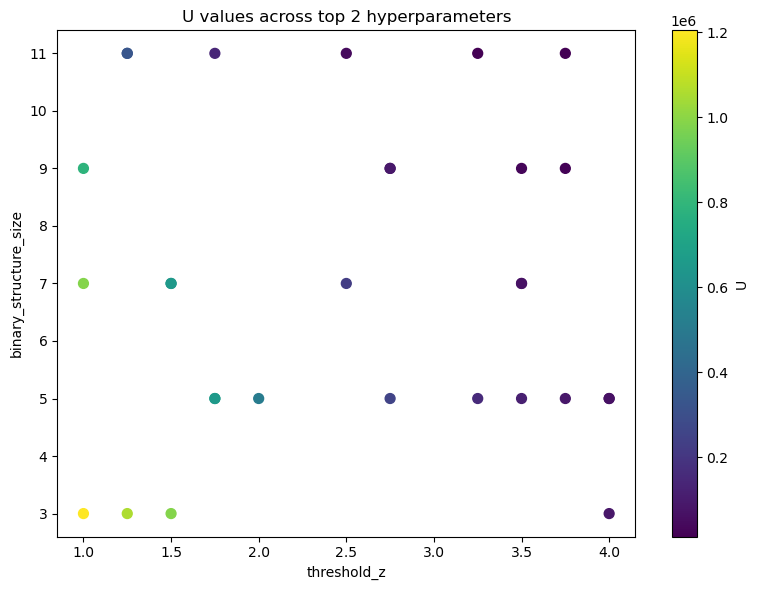

In [5]:
if dev_mode > 0:
    plt.figure(figsize=(8, 6))
    plt.scatter(rrr_clean[top_h1], rrr_clean[top_h2], c=U, cmap='viridis', s=50)
    plt.xlabel(f"{top_h1}")
    plt.ylabel(f"{top_h2}")
    plt.title("U values across top 2 hyperparameters")
    cbar = plt.colorbar()
    cbar.set_label("U")
    plt.tight_layout()
    plt.show()

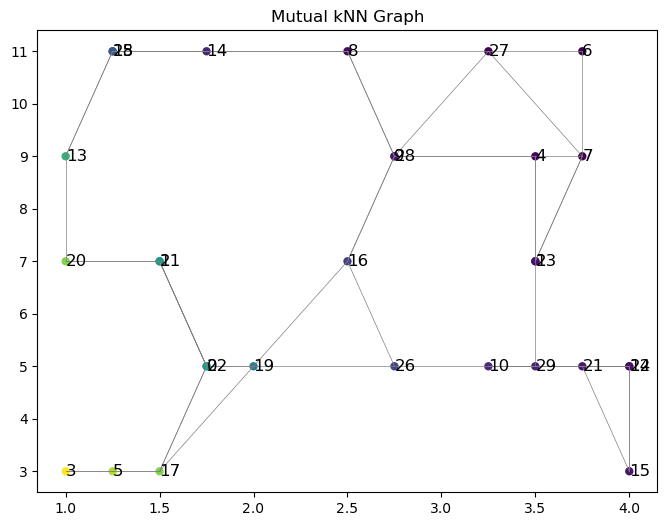

In [6]:
if dev_mode > 0:
    # visualize the mutual kNN graph
    H_2d = H_clean.to_numpy()
    rows, cols = mutual_knn.nonzero()
    # plot nodes
    plt.figure(figsize=(8, 6))
    plt.scatter(H_2d[:, 0], H_2d[:, 1], c=U, s=25)
    # plot node IDs
    for i, (x, y) in enumerate(H_2d):
        plt.text(x, y, str(i), fontsize=12, ha='left', va='center', color='black')
    # plot edges (mutual connections)
    rows, cols = mutual_knn.nonzero()
    for i, j in zip(rows, cols):
        if i < j:  # Avoid duplicate edges
            plt.plot([H_2d[i, 0], H_2d[j, 0]], [H_2d[i, 1], H_2d[j, 1]], 'gray', linewidth=0.5)

    plt.title("Mutual kNN Graph")
    #plt.axis('equal')
    plt.show()
    

In [8]:
# this is for smoothness based selection

#k = 5
#graph_run = 1
#while graph_run > 0:
#    nbrs = NearestNeighbors(n_neighbors=k).fit(H_scaled)
#    # compute the graph of k-Neighbors, the graph is a sparse matrix in csr format
#    knn_graph = nbrs.kneighbors_graph(mode='connectivity')
#    mutual_knn = knn_graph.minimum(knn_graph.T).tocsr()
#    # we include node itself in neighbors because std is relative to node itself 
#    neighbors = [np.append(i, mutual_knn[i].indices) for i in range(mutual_knn.shape[0])]
#    local_std = np.array([
#        np.std(U[neigh]) if len(neigh) > 1 else -1
#        for neigh in neighbors
#    ])
#    isolated_count = np.sum(local_std == -1)
#    if isolated_count > 0:
#        k = k+1
#        graph_run = graph_run + 1
#    else:
#        graph_run = -1

#stable_idx = np.argsort(local_std)[0]
#hp_selected = rrr.iloc[stable_idx, :-1]